In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.metrics import roc_auc_score

In [ ]:
df = pd.read_csv("diabetes2_cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               761 non-null    float64
 1   Glucose                   761 non-null    float64
 2   Insulin                   761 non-null    float64
 3   BMI                       761 non-null    float64
 4   DiabetesPedigreeFunction  761 non-null    float64
 5   Age                       761 non-null    float64
 6   Outcome                   761 non-null    float64
dtypes: float64(7)
memory usage: 41.7 KB


In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction',
       'Age', 'Outcome'],
      dtype='object')

#### heat map

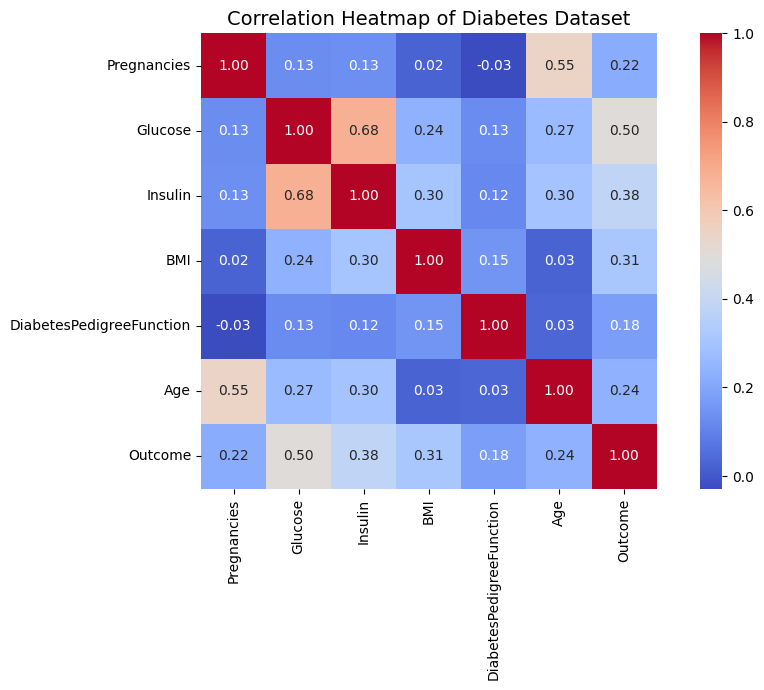

In [ ]:
# คำนวณค่า correlation matrix
corr = df.corr()

# วาด heatmap
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap of Diabetes Dataset", fontsize=14)
plt.tight_layout()
plt.show()

### เปลี่ยนวิธีการเช็คค่า correlation เป็น Point-Biserial correlation แทน เนื่องจาก Outcome เป็น binary

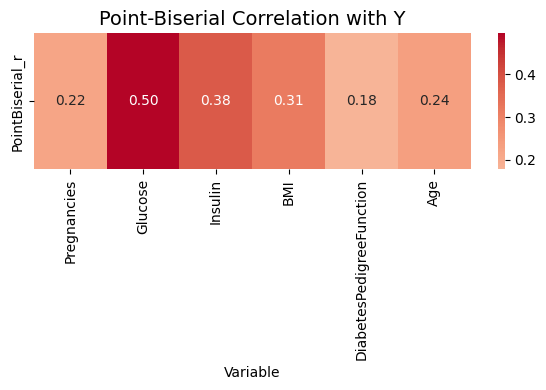

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

# ---------- สมมติ df มีคอลัมน์ X1...X6 และ y ----------
X_cols = [col for col in df.columns if col != 'Outcome']

# คำนวณ point-biserial correlation
corrs = []
for col in X_cols:
    r, p = pointbiserialr(df[col], df['Outcome'])
    corrs.append(r)

# รวมเป็น DataFrame
corr_df = pd.DataFrame({'Variable': X_cols, 'PointBiserial_r': corrs}).set_index('Variable')

# ---------- วาด heatmap ----------
plt.figure(figsize=(6,4))
sns.heatmap(corr_df.T, annot=True, cmap="coolwarm", center=0, fmt=".2f", cbar=True)
plt.title("Point-Biserial Correlation with Y", fontsize=14)
plt.tight_layout()
plt.show()


### Check Linearity of the logit
(ความสัมพันธ์ระหว่างตัวแปรอิสระกับ logit ของผลลัพธ์ต้องเป็นเชิงเส้น) ถ้า p-value > 0.05 แปลว่า ไม่มีนัยสำคัญ → ไม่พบความไม่เป็นเชิงเส้น
ซึ่ง ดี → ถือว่า “Linearity in the Logit” ถูกต้อง

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# สมมติ df มี y (binary) และ x1-x6 (continuous)
for col in ['Pregnancies','Glucose','Insulin','BMI','DiabetesPedigreeFunction','Age']:
    df[f'{col}_log'] = df[col] * np.log(df[col] + 1e-8)

X = sm.add_constant(df[['Pregnancies','Glucose','Insulin','BMI','DiabetesPedigreeFunction','Age',
                        'Pregnancies_log','Glucose_log','Insulin_log','BMI_log','DiabetesPedigreeFunction_log','Age_log']])
model = sm.Logit(df['Outcome'], X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.441162
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  761
Model:                          Logit   Df Residuals:                      748
Method:                           MLE   Df Model:                           12
Date:                Wed, 15 Oct 2025   Pseudo R-squ.:                  0.3192
Time:                        12:11:33   Log-Likelihood:                -335.72
converged:                       True   LL-Null:                       -493.11
Covariance Type:            nonrobust   LLR p-value:                 3.704e-60
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -43.4115      9.726     -4.464      0.000

#### อาจารย์ Logistic

In [ ]:
X = df.drop(columns=["Outcome"])
y = df["Outcome"]

In [ ]:
# VIF
# Target & Features
#y = df["Outcome"]
#X = df.drop(columns=["Outcome"])

# ---------------------------
# VIF Calculation
# ---------------------------
def calculate_vif(X):
    X_const = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X_const.values, i+1)  # +1 to skip intercept
        for i in range(len(X.columns))
    ]
    return vif_data

vif_table = calculate_vif(X)

print("\n📊 Variance Inflation Factor (VIF) Table:\n")
print(vif_table.sort_values(by="VIF", ascending=False))



📊 Variance Inflation Factor (VIF) Table:

                    Feature       VIF
2                   Insulin  2.010662
1                   Glucose  1.890021
5                       Age  1.562610
0               Pregnancies  1.436224
3                       BMI  1.125045
4  DiabetesPedigreeFunction  1.035186


#### ปรับให้ทำ train test ก่อนทำ AIC

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# ---------- helper function: fit logistic และคืนค่า AIC ----------
def fit_logit_aic(y, X_cols, df_train):
    X = sm.add_constant(df_train[X_cols], has_constant='add')
    try:
        model = sm.Logit(y, X).fit(disp=0)
        return model, model.aic
    except Exception:
        return None, np.inf

# ---------- stepwise AIC ----------
def stepwise_aic(y, candidate_cols, df_train, direction="both", tol=1e-4, max_steps=100):
    selected = []
    current_aic = np.inf
    history = []

    for step in range(max_steps):
        improved = False

        # forward
        remaining = [c for c in candidate_cols if c not in selected]
        best_add, best_add_aic = None, np.inf
        for c in remaining:
            model, aic = fit_logit_aic(y, selected + [c], df_train)
            if aic < best_add_aic:
                best_add, best_add_aic = c, aic
        if best_add is not None and best_add_aic + tol < current_aic:
            selected.append(best_add)
            current_aic = best_add_aic
            history.append(("add", best_add, current_aic))
            improved = True

        # backward
        if direction in ("both", "backward") and len(selected) > 1:
            worst_drop, best_drop_aic = None, current_aic
            for c in list(selected):
                cols = [x for x in selected if x != c]
                model, aic = fit_logit_aic(y, cols, df_train)
                if aic + tol < best_drop_aic:
                    best_drop_aic, worst_drop = aic, c
            if worst_drop is not None:
                selected.remove(worst_drop)
                current_aic = best_drop_aic
                history.append(("drop", worst_drop, current_aic))
                improved = True

        if not improved:
            break

    final_model, final_aic = fit_logit_aic(y, selected, df_train)
    return selected, final_aic, final_model, pd.DataFrame(history, columns=["action","feature","AIC"])

# ---------- KFold cross-validation ----------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X_all = df.drop(columns=["Outcome"])
y_all = df["Outcome"]

for fold, (train_index, test_index) in enumerate(kf.split(X_all, y_all), 1):
    # train/test split
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]

    df_train = pd.concat([X_train, y_train], axis=1)

    # ---------- เลือกตัวแปรด้วย stepwise AIC บน training set ----------
    selected, final_aic, final_model, hist = stepwise_aic(
        y_train, list(X_train.columns), df_train, direction="both"
    )

    # ---------- แสดงผลที่ต้องการ ----------
    print(f"\n===== Fold {fold} =====")
    print("Selected variables:", selected)
    print("Final AIC:", final_aic)
    print("\nStepwise history:")
    print(hist)

    print("\nCoefficient summary:")
    print(final_model.summary2().tables[1])  # ตาราง coef, std err, z, p-value, CI

    # ---------- logistic regression (sklearn) ----------
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train[selected], y_train)

    # predict
    y_pred = model.predict(X_test[selected])
    y_prob = model.predict_proba(X_test[selected])[:, 1]

    # metrics
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

print("\nOverall Mean Accuracy:", np.mean(accuracies))
print("Overall Mean AUC:", np.mean(aucs))



===== Fold 1 =====
Selected variables: ['Glucose', 'BMI', 'Pregnancies', 'DiabetesPedigreeFunction', 'DiabetesPedigreeFunction_log', 'BMI_log']
Final AIC: 557.7739254992939

Stepwise history:
  action                       feature         AIC
0    add                       Glucose  623.359632
1    add                           BMI  588.367725
2    add                   Pregnancies  568.669961
3    add      DiabetesPedigreeFunction  560.203779
4    add  DiabetesPedigreeFunction_log  558.547298
5    add                       BMI_log  557.773925

Coefficient summary:
                                  Coef.  Std.Err.         z         P>|z|  \
const                        -17.578724  3.985415 -4.410764  1.030068e-05   
Glucose                        0.038538  0.003994  9.649128  4.957537e-22   
BMI                            0.950296  0.507235  1.873483  6.100171e-02   
Pregnancies                    0.138628  0.031108  4.456396  8.334903e-06   
DiabetesPedigreeFunction       2.297164  0.

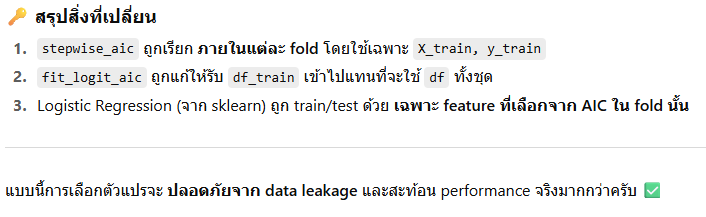

### สร้างโมเดล Classification ด้วย Random forest พร้อมแสดงผลเหมือนกัน

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# ---------- KFold cross-validation ----------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X_all = df.drop(columns=["Outcome"])
y_all = df["Outcome"]

for fold, (train_index, test_index) in enumerate(kf.split(X_all, y_all), 1):
    # train/test split
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]

    # ---------- Train Random Forest ----------
    model = RandomForestClassifier(
        n_estimators=200, random_state=42, max_depth=None, class_weight="balanced"
    )
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # metrics
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # ---------- แสดงผล ----------
    print(f"\n===== Fold {fold} =====")
    print("Accuracy:", acc)
    print("AUC:", roc_auc)

    # Feature importance
    feat_imp = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    print("\nFeature importance:")
    print(feat_imp)

print("\nOverall Mean Accuracy:", np.mean(accuracies))
print("Overall Mean AUC:", np.mean(aucs))



===== Fold 1 =====
Accuracy: 0.7189542483660131
AUC: 0.773194912083801

Feature importance:
                         Feature  Importance
1                        Glucose    0.142287
7                    Glucose_log    0.128801
8                    Insulin_log    0.102167
2                        Insulin    0.089179
9                        BMI_log    0.085555
3                            BMI    0.084624
4       DiabetesPedigreeFunction    0.081824
11                       Age_log    0.073968
5                            Age    0.072728
10  DiabetesPedigreeFunction_log    0.061052
0                    Pregnancies    0.040756
6                Pregnancies_log    0.037060

===== Fold 2 =====
Accuracy: 0.7697368421052632
AUC: 0.826530612244898

Feature importance:
                         Feature  Importance
1                        Glucose    0.139556
7                    Glucose_log    0.125727
2                        Insulin    0.107358
3                            BMI    0.102534
8   

### สร้างโมเดล Classification ด้วย LightGBM พร้อมแสดงผลเหมือนกัน

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# ---------- KFold cross-validation ----------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X_all = df.drop(columns=["Outcome"])
y_all = df["Outcome"]

for fold, (train_index, test_index) in enumerate(kf.split(X_all, y_all), 1):
    # train/test split
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]

    # ---------- Train LightGBM ----------
    model = LGBMClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced",
        objective="binary",
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # metrics
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # ---------- แสดงผล ----------
    print(f"\n===== Fold {fold} =====")
    print("Accuracy:", acc)
    print("AUC:", roc_auc)

    # Feature importance
    feat_imp = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    print("\nFeature importance:")
    print(feat_imp)

print("\nOverall Mean Accuracy:", np.mean(accuracies))
print("Overall Mean AUC:", np.mean(aucs))


[LightGBM] [Info] Number of positive: 213, number of negative: 395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1419
[LightGBM] [Info] Number of data points in the train set: 608, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

### แสดงผลเปรียบกันกันระหว่าง Logistic regression และ Classification ด้วย Random forest

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.model_selection import StratifiedKFold

# ---------- KFold cross-validation ----------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# เก็บผลลัพธ์แยกตามโมเดล
results = {
    "LogisticRegression": {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [],
                           "conf_matrix": [], "report": []},
    "RandomForest": {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [],
                     "conf_matrix": [], "report": []}
}

X_all = df.drop(columns=["Outcome"])
y_all = df["Outcome"]

for fold, (train_index, test_index) in enumerate(kf.split(X_all, y_all), 1):
    print(f"\n===== Fold {fold} =====")

    # train/test split
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]

    # ---------- Logistic Regression ----------
    log_model = LogisticRegression(random_state=42, max_iter=1000)
    log_model.fit(X_train, y_train)

    y_pred_log = log_model.predict(X_test)
    y_prob_log = log_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred_log)
    prec = precision_score(y_test, y_pred_log)
    rec = recall_score(y_test, y_pred_log)
    f1 = f1_score(y_test, y_pred_log)
    fpr, tpr, _ = roc_curve(y_test, y_prob_log)
    roc_auc = auc(fpr, tpr)

    results["LogisticRegression"]["accuracy"].append(acc)
    results["LogisticRegression"]["precision"].append(prec)
    results["LogisticRegression"]["recall"].append(rec)
    results["LogisticRegression"]["f1"].append(f1)
    results["LogisticRegression"]["auc"].append(roc_auc)
    results["LogisticRegression"]["conf_matrix"].append(confusion_matrix(y_test, y_pred_log))
    results["LogisticRegression"]["report"].append(classification_report(y_test, y_pred_log, output_dict=True))

    print("Logistic Regression → Acc: %.3f, Prec: %.3f, Rec: %.3f, F1: %.3f, AUC: %.3f" %
          (acc, prec, rec, f1, roc_auc))

    # ---------- Random Forest ----------
    rf_model = RandomForestClassifier(
        n_estimators=200, random_state=42, max_depth=None, class_weight="balanced"
    )
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred_rf)
    prec = precision_score(y_test, y_pred_rf)
    rec = recall_score(y_test, y_pred_rf)
    f1 = f1_score(y_test, y_pred_rf)
    fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
    roc_auc = auc(fpr, tpr)

    results["RandomForest"]["accuracy"].append(acc)
    results["RandomForest"]["precision"].append(prec)
    results["RandomForest"]["recall"].append(rec)
    results["RandomForest"]["f1"].append(f1)
    results["RandomForest"]["auc"].append(roc_auc)
    results["RandomForest"]["conf_matrix"].append(confusion_matrix(y_test, y_pred_rf))
    results["RandomForest"]["report"].append(classification_report(y_test, y_pred_rf, output_dict=True))

    print("Random Forest       → Acc: %.3f, Prec: %.3f, Rec: %.3f, F1: %.3f, AUC: %.3f" %
          (acc, prec, rec, f1, roc_auc))


# ---------- แสดงผลรวมเฉลี่ย ----------
print("\n===== Mean Results (5-fold CV) =====")
for model_name in results.keys():
    print(f"\nModel: {model_name}")
    print("Accuracy:  %.3f" % np.mean(results[model_name]["accuracy"]))
    print("Precision: %.3f" % np.mean(results[model_name]["precision"]))
    print("Recall:    %.3f" % np.mean(results[model_name]["recall"]))
    print("F1-score:  %.3f" % np.mean(results[model_name]["f1"]))
    print("AUC-ROC:   %.3f" % np.mean(results[model_name]["auc"]))



===== Fold 1 =====


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression → Acc: 0.732, Prec: 0.676, Rec: 0.463, F1: 0.549, AUC: 0.801
Random Forest       → Acc: 0.719, Prec: 0.634, Rec: 0.481, F1: 0.547, AUC: 0.773

===== Fold 2 =====


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression → Acc: 0.789, Prec: 0.762, Rec: 0.593, F1: 0.667, AUC: 0.846
Random Forest       → Acc: 0.770, Prec: 0.694, Rec: 0.630, F1: 0.660, AUC: 0.827

===== Fold 3 =====


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression → Acc: 0.816, Prec: 0.805, Rec: 0.623, F1: 0.702, AUC: 0.897
Random Forest       → Acc: 0.822, Prec: 0.760, Rec: 0.717, F1: 0.738, AUC: 0.873

===== Fold 4 =====


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression → Acc: 0.763, Prec: 0.660, Rec: 0.660, F1: 0.660, AUC: 0.827
Random Forest       → Acc: 0.750, Prec: 0.627, Rec: 0.698, F1: 0.661, AUC: 0.823

===== Fold 5 =====


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression → Acc: 0.770, Prec: 0.750, Rec: 0.509, F1: 0.607, AUC: 0.833
Random Forest       → Acc: 0.776, Prec: 0.757, Rec: 0.528, F1: 0.622, AUC: 0.865

===== Mean Results (5-fold CV) =====

Model: LogisticRegression
Accuracy:  0.774
Precision: 0.731
Recall:    0.570
F1-score:  0.637
AUC-ROC:   0.841

Model: RandomForest
Accuracy:  0.767
Precision: 0.694
Recall:    0.611
F1-score:  0.646
AUC-ROC:   0.832


### แสดงผลเปรียบกันกันระหว่าง Logistic regression และ Classification ด้วย Random forest และ LightGBM


===== Fold 1 =====


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression → Acc: 0.732, Prec: 0.676, Rec: 0.463, F1: 0.549, AUC: 0.801
RandomForest       → Acc: 0.719, Prec: 0.634, Rec: 0.481, F1: 0.547, AUC: 0.773
[LightGBM] [Info] Number of positive: 213, number of negative: 395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1419
[LightGBM] [Info] Number of data points in the train set: 608, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression → Acc: 0.789, Prec: 0.762, Rec: 0.593, F1: 0.667, AUC: 0.846
RandomForest       → Acc: 0.770, Prec: 0.694, Rec: 0.630, F1: 0.660, AUC: 0.827
[LightGBM] [Info] Number of positive: 213, number of negative: 396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1420
[LightGBM] [Info] Number of data points in the train set: 609, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression → Acc: 0.816, Prec: 0.805, Rec: 0.623, F1: 0.702, AUC: 0.897
RandomForest       → Acc: 0.822, Prec: 0.760, Rec: 0.717, F1: 0.738, AUC: 0.873
[LightGBM] [Info] Number of positive: 214, number of negative: 395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1420
[LightGBM] [Info] Number of data points in the train set: 609, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression → Acc: 0.763, Prec: 0.660, Rec: 0.660, F1: 0.660, AUC: 0.827
RandomForest       → Acc: 0.750, Prec: 0.627, Rec: 0.698, F1: 0.661, AUC: 0.823
[LightGBM] [Info] Number of positive: 214, number of negative: 395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 609, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression → Acc: 0.770, Prec: 0.750, Rec: 0.509, F1: 0.607, AUC: 0.833
RandomForest       → Acc: 0.776, Prec: 0.757, Rec: 0.528, F1: 0.622, AUC: 0.865
[LightGBM] [Info] Number of positive: 214, number of negative: 395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 609, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

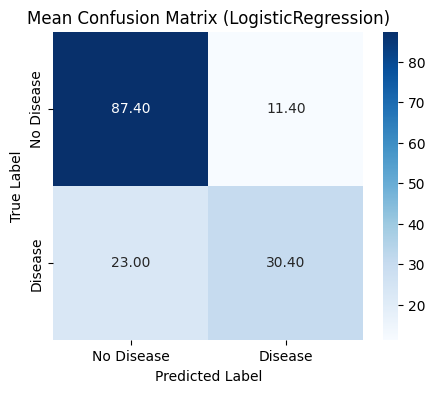


Model: RandomForest
Accuracy:  0.767
Precision: 0.694
Recall:    0.611
F1-score:  0.646
AUC-ROC:   0.832


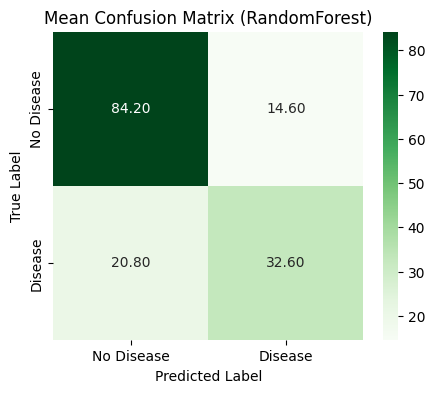


Model: LightGBM
Accuracy:  0.752
Precision: 0.641
Recall:    0.675
F1-score:  0.653
AUC-ROC:   0.819


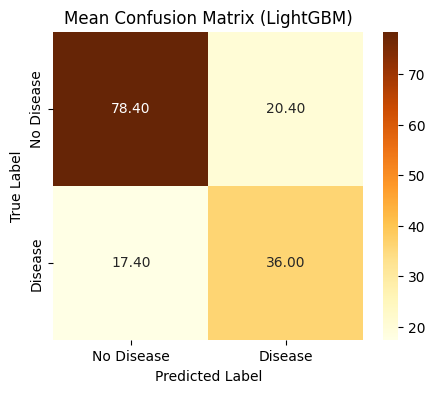

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.model_selection import StratifiedKFold

# ---------- ตั้งค่า Cross-validation ----------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# เก็บผลลัพธ์แยกตามโมเดล
results = {
    "LogisticRegression": {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [],
                           "conf_matrix": [], "report": []},
    "RandomForest": {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [],
                     "conf_matrix": [], "report": []},
    "LightGBM": {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [],
                 "conf_matrix": [], "report": []}
}

X_all = df.drop(columns=["Outcome"])
y_all = df["Outcome"]

# ---------- เริ่ม Cross-validation ----------
for fold, (train_index, test_index) in enumerate(kf.split(X_all, y_all), 1):
    print(f"\n===== Fold {fold} =====")

    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]

    # ==========================================================
    # Logistic Regression
    # ==========================================================
    log_model = LogisticRegression(random_state=42, max_iter=1000)
    log_model.fit(X_train, y_train)
    y_pred_log = log_model.predict(X_test)
    y_prob_log = log_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred_log)
    prec = precision_score(y_test, y_pred_log)
    rec = recall_score(y_test, y_pred_log)
    f1 = f1_score(y_test, y_pred_log)
    fpr, tpr, _ = roc_curve(y_test, y_prob_log)
    roc_auc = auc(fpr, tpr)

    results["LogisticRegression"]["accuracy"].append(acc)
    results["LogisticRegression"]["precision"].append(prec)
    results["LogisticRegression"]["recall"].append(rec)
    results["LogisticRegression"]["f1"].append(f1)
    results["LogisticRegression"]["auc"].append(roc_auc)
    results["LogisticRegression"]["conf_matrix"].append(confusion_matrix(y_test, y_pred_log))
    results["LogisticRegression"]["report"].append(classification_report(y_test, y_pred_log, output_dict=True))

    print("LogisticRegression → Acc: %.3f, Prec: %.3f, Rec: %.3f, F1: %.3f, AUC: %.3f" %
          (acc, prec, rec, f1, roc_auc))

    # ==========================================================
    # Random Forest
    # ==========================================================
    rf_model = RandomForestClassifier(
        n_estimators=200, random_state=42, max_depth=None, class_weight="balanced"
    )
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred_rf)
    prec = precision_score(y_test, y_pred_rf)
    rec = recall_score(y_test, y_pred_rf)
    f1 = f1_score(y_test, y_pred_rf)
    fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
    roc_auc = auc(fpr, tpr)

    results["RandomForest"]["accuracy"].append(acc)
    results["RandomForest"]["precision"].append(prec)
    results["RandomForest"]["recall"].append(rec)
    results["RandomForest"]["f1"].append(f1)
    results["RandomForest"]["auc"].append(roc_auc)
    results["RandomForest"]["conf_matrix"].append(confusion_matrix(y_test, y_pred_rf))
    results["RandomForest"]["report"].append(classification_report(y_test, y_pred_rf, output_dict=True))

    print("RandomForest       → Acc: %.3f, Prec: %.3f, Rec: %.3f, F1: %.3f, AUC: %.3f" %
          (acc, prec, rec, f1, roc_auc))

    # ==========================================================
    # LightGBM
    # ==========================================================
    lgb_model = LGBMClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced",
        objective="binary",
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        n_jobs=-1
    )
    lgb_model.fit(X_train, y_train)
    y_pred_lgb = lgb_model.predict(X_test)
    y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred_lgb)
    prec = precision_score(y_test, y_pred_lgb)
    rec = recall_score(y_test, y_pred_lgb)
    f1 = f1_score(y_test, y_pred_lgb)
    fpr, tpr, _ = roc_curve(y_test, y_prob_lgb)
    roc_auc = auc(fpr, tpr)

    results["LightGBM"]["accuracy"].append(acc)
    results["LightGBM"]["precision"].append(prec)
    results["LightGBM"]["recall"].append(rec)
    results["LightGBM"]["f1"].append(f1)
    results["LightGBM"]["auc"].append(roc_auc)
    results["LightGBM"]["conf_matrix"].append(confusion_matrix(y_test, y_pred_lgb))
    results["LightGBM"]["report"].append(classification_report(y_test, y_pred_lgb, output_dict=True))

    print("LightGBM           → Acc: %.3f, Prec: %.3f, Rec: %.3f, F1: %.3f, AUC: %.3f" %
          (acc, prec, rec, f1, roc_auc))


# ==========================================================
# สรุปผลลัพธ์เฉลี่ยของแต่ละโมเดล
# ==========================================================
print("\n===== Mean Results (5-fold CV) =====")
for model_name in results.keys():
    print(f"\nModel: {model_name}")
    print("Accuracy:  %.3f" % np.mean(results[model_name]["accuracy"]))
    print("Precision: %.3f" % np.mean(results[model_name]["precision"]))
    print("Recall:    %.3f" % np.mean(results[model_name]["recall"]))
    print("F1-score:  %.3f" % np.mean(results[model_name]["f1"]))
    print("AUC-ROC:   %.3f" % np.mean(results[model_name]["auc"]))

    # ---------- แสดง Mean Confusion Matrix ----------
    mean_conf_matrix = np.mean(results[model_name]["conf_matrix"], axis=0)
    plt.figure(figsize=(5, 4))

    # 🔹 ตั้งค่าสีแยกตามโมเดล
    if model_name == "LogisticRegression":
        cmap_color = "Blues"       # สีน้ำเงิน
    elif model_name == "RandomForest":
        cmap_color = "Greens"      # สีเขียว
    elif model_name == "LightGBM":
        cmap_color = "YlOrBr"      # สีเหลือง-น้ำตาลอ่อน
    else:
        cmap_color = "Blues"       # เผื่อมีโมเดลอื่น

    sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap=cmap_color,
                xticklabels=["No Disease", "Disease"],
                yticklabels=["No Disease", "Disease"])
    plt.title(f"Mean Confusion Matrix ({model_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### ------------------------------------------------------------------------------------------------------------

### ------------------------------------------------------------------------------------------------------------

### ------------------------------------------------------------------------------------------------------------\

### ภาคผนวก (โค้ดที่เคยเขียนไป)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


===== LogisticRegression (5-fold mean) =====
Accuracy:  0.7740
Precision: 0.7306
Recall:    0.5696
F1-score:  0.6371
AUC-ROC:   0.8407


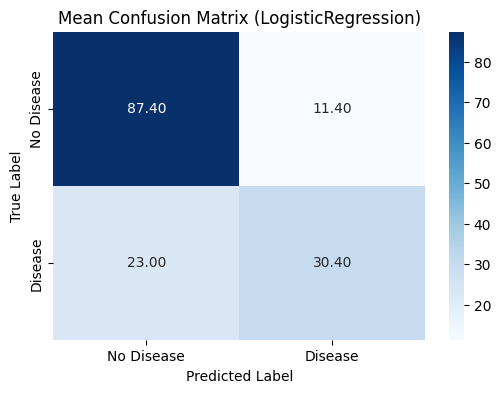


===== RandomForest (5-fold mean) =====
Accuracy:  0.7675
Precision: 0.6944
Recall:    0.6109
F1-score:  0.6457
AUC-ROC:   0.8323


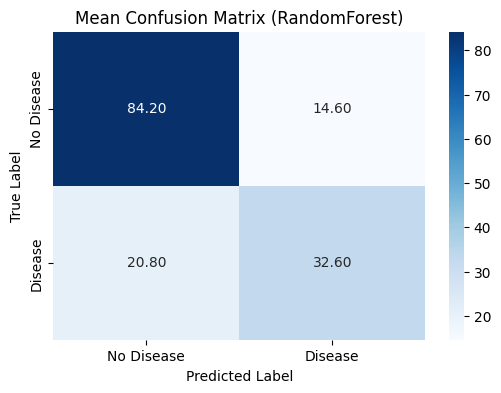

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.model_selection import StratifiedKFold

# ---------- KFold cross-validation ----------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# เก็บผลลัพธ์แยกตามโมเดล
results = {
    "LogisticRegression": {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [],
                           "conf_matrix": []},
    "RandomForest": {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [],
                     "conf_matrix": []}
}

X_all = df.drop(columns=["Outcome"])
y_all = df["Outcome"]

for fold, (train_index, test_index) in enumerate(kf.split(X_all, y_all), 1):
    # train/test split
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]

    # ---------- Logistic Regression ----------
    log_model = LogisticRegression(random_state=42, max_iter=1000)
    log_model.fit(X_train, y_train)

    y_pred_log = log_model.predict(X_test)
    y_prob_log = log_model.predict_proba(X_test)[:, 1]

    results["LogisticRegression"]["accuracy"].append(accuracy_score(y_test, y_pred_log))
    results["LogisticRegression"]["precision"].append(precision_score(y_test, y_pred_log))
    results["LogisticRegression"]["recall"].append(recall_score(y_test, y_pred_log))
    results["LogisticRegression"]["f1"].append(f1_score(y_test, y_pred_log))
    fpr, tpr, _ = roc_curve(y_test, y_prob_log)
    results["LogisticRegression"]["auc"].append(auc(fpr, tpr))
    results["LogisticRegression"]["conf_matrix"].append(confusion_matrix(y_test, y_pred_log))

    # ---------- Random Forest ----------
    rf_model = RandomForestClassifier(
        n_estimators=200, random_state=42, max_depth=None, class_weight="balanced"
    )
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

    results["RandomForest"]["accuracy"].append(accuracy_score(y_test, y_pred_rf))
    results["RandomForest"]["precision"].append(precision_score(y_test, y_pred_rf))
    results["RandomForest"]["recall"].append(recall_score(y_test, y_pred_rf))
    results["RandomForest"]["f1"].append(f1_score(y_test, y_pred_rf))
    fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
    results["RandomForest"]["auc"].append(auc(fpr, tpr))
    results["RandomForest"]["conf_matrix"].append(confusion_matrix(y_test, y_pred_rf))

# ---------- แสดงผลรวมเฉลี่ย ----------
for model_name in results.keys():
    print(f"\n===== {model_name} (5-fold mean) =====")
    print("Accuracy:  %.4f" % np.mean(results[model_name]["accuracy"]))
    print("Precision: %.4f" % np.mean(results[model_name]["precision"]))
    print("Recall:    %.4f" % np.mean(results[model_name]["recall"]))
    print("F1-score:  %.4f" % np.mean(results[model_name]["f1"]))
    print("AUC-ROC:   %.4f" % np.mean(results[model_name]["auc"]))

    # ---------- Confusion Matrix (Mean) ----------
    mean_conf_matrix = np.mean(results[model_name]["conf_matrix"], axis=0)

    plt.figure(figsize=(6, 4))
    sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["No Disease", "Disease"],
                yticklabels=["No Disease", "Disease"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Mean Confusion Matrix ({model_name})")
    plt.show()


In [ ]:
# AIC

X_all = df.drop(columns=["Outcome"])


# ---------- helper function: fit logistic และคืนค่า AIC ----------
def fit_logit_aic(y, X_cols):
    X = sm.add_constant(df[X_cols], has_constant='add')
    try:
        model = sm.Logit(y, X).fit(disp=0)
        return model, model.aic
    except Exception:
        return None, np.inf

# ---------- stepwise AIC ----------
def stepwise_aic(y, candidate_cols, direction="both", tol=1e-4, max_steps=100):
    selected = []
    current_aic = np.inf
    history = []

    for step in range(max_steps):
        improved = False

        # forward
        remaining = [c for c in candidate_cols if c not in selected]
        best_add, best_add_aic = None, np.inf
        for c in remaining:
            model, aic = fit_logit_aic(y, selected + [c])
            if aic < best_add_aic:
                best_add, best_add_aic = c, aic
        if best_add is not None and best_add_aic + tol < current_aic:
            selected.append(best_add)
            current_aic = best_add_aic
            history.append(("add", best_add, current_aic))
            improved = True

        # backward
        if direction in ("both", "backward") and len(selected) > 1:
            worst_drop, best_drop_aic = None, current_aic
            for c in list(selected):
                cols = [x for x in selected if x != c]
                model, aic = fit_logit_aic(y, cols)
                if aic + tol < best_drop_aic:
                    best_drop_aic, worst_drop = aic, c
            if worst_drop is not None:
                selected.remove(worst_drop)
                current_aic = best_drop_aic
                history.append(("drop", worst_drop, current_aic))
                improved = True

        if not improved:
            break

    final_model, final_aic = fit_logit_aic(y, selected)
    return selected, final_aic, final_model, pd.DataFrame(history, columns=["action","feature","AIC"])

# ---------- run ----------
selected, final_aic, final_model, hist = stepwise_aic(y, list(X_all.columns), direction="both")
selected, final_aic, hist.tail(10), final_model.summary2().tables[1].head()


(['Glucose', 'BMI', 'Pregnancies_log', 'DiabetesPedigreeFunction', 'BMI_log'],
 np.float64(714.5371931934399),
   action                   feature         AIC
 0    add                   Glucose  789.770049
 1    add                       BMI  750.594725
 2    add           Pregnancies_log  727.351015
 3    add  DiabetesPedigreeFunction  719.106710
 4    add                   BMI_log  714.537193,
                               Coef.  Std.Err.          z         P>|z|  \
 const                    -17.857518  3.625831  -4.925082  8.432487e-07   
 Glucose                    0.037105  0.003521  10.538760  5.724851e-26   
 BMI                        1.248027  0.464879   2.684626  7.261108e-03   
 Pregnancies_log            0.054328  0.011138   4.877890  1.072265e-06   
 DiabetesPedigreeFunction   1.520057  0.483656   3.142846  1.673139e-03   
 
                              [0.025     0.975]  
 const                    -24.964017 -10.751019  
 Glucose                    0.030204   0.044006 

In [ ]:
#step 2 แบ่ง training เเละ testing
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# เก็บผลลัพธ์
# เตรียมตัวแปรเพื่อเก็บผลลัพธ์
accuracies = []
conf_matrices = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train_index, test_index in kf.split(X, y):
    # แบ่งข้อมูลในแต่ละ fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # สร้างและฝึกโมเดล Logistic Regression
    # เพิ่ม max_iter=1000 เพื่อช่วยให้โมเดลเรียนรู้จนเสร็จสมบูรณ์
    model = LogisticRegression(random_state=42, max_iter=1000) # <--- เปลี่ยนโมเดลตรงนี้
    model.fit(X_train, y_train)

    # ทำนายผล
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # ค่าความน่าจะเป็นของ class 1

    #step 3 คำนวณ Accuracy, Confusion Matrix, ROC Curve
    # คำนวณและเก็บ Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # เก็บ Confusion Matrix
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    # คำนวณและเก็บค่า ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
#--- สรุปผลการประเมินโมเดลทั้งหมด ---

print("\n" + "="*40)
print(f"📊 Model Evaluation Summary: SVM")
print("="*40)

# 1. คำนวณค่า Mean Accuracy จากทุก fold
print(f"Mean Accuracy : {np.mean(accuracies):.4f}")

# 2. คำนวณค่า Mean AUC จากทุก fold
print(f"Mean AUC      : {np.mean(aucs):.4f}")

# 3. คำนวณ Precision, Recall, F1-Score จาก Mean Confusion Matrix
# ดึงค่า TN, FP, FN, TP โดยเฉลี่ยออกมา
mean_tn, mean_fp, mean_fn, mean_tp = np.mean(conf_matrices, axis=0).ravel()

# คำนวณค่าเฉลี่ยของเมตริกต่างๆ
mean_precision = mean_tp / (mean_tp + mean_fp)
mean_recall = mean_tp / (mean_tp + mean_fn) # หรือเรียกว่า Sensitivity
mean_f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)

print(f"Mean Precision: {mean_precision:.4f}") # ความแม่นยำของผลลัพธ์ที่เป็นบวก
print(f"Mean Recall   : {mean_recall:.4f}") # ความสามารถในการตรวจจับผลลัพธ์ที่เป็นบวก
print(f"Mean F1-Score : {mean_f1_score:.4f}") # ค่าเฉลี่ยระหว่าง Precision และ Recall
print("="*40)


📊 Model Evaluation Summary: SVM
Mean Accuracy : 0.7740
Mean AUC      : 0.8407
Mean Precision: 0.7273
Mean Recall   : 0.5693
Mean F1-Score : 0.6387


Mean Accuracy (Logistic Regression): 0.7740


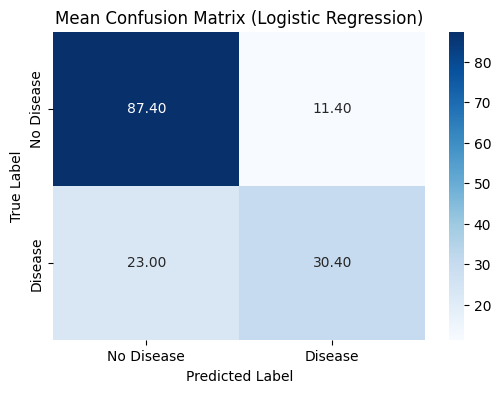

In [ ]:
print(f"Mean Accuracy (Logistic Regression): {np.mean(accuracies):.4f}")
# แสดงค่าเฉลี่ยของ Confusion Matrix
mean_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(6, 4))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Mean Confusion Matrix (Logistic Regression)")
plt.show()

#### chatgpt

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# เก็บผลลัพธ์
accuracies, precisions, recalls, f1s, aucs, conf_matrices = [], [], [], [], [], []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

# --- ตั้ง threshold ที่อยากลอง (ลดลงเพื่อดัน recall ให้สูงขึ้น) ---
THRESHOLD = 0.40  # ลอง 0.40 หรือ 0.35

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # โมเดล + สเกล + class_weight
    model = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            random_state=42,
            max_iter=5000,
            class_weight="balanced",  # สำคัญต่อการดัน recall
            C=1.0,                    # ลองลด C=0.5 หรือ 0.1 ถ้าอยากเพิ่ม regularization
            solver="lbfgs"
        ))
    ])

    model.fit(X_train, y_train)

    # ความน่าจะเป็น class 1
    y_prob = model.predict_proba(X_test)[:, 1]

    # ปรับ threshold เพื่อทำนาย label
    y_pred = (y_prob >= THRESHOLD).astype(int)

    # metric ต่อ fold
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    # ROC / AUC (ไม่ขึ้นกับ threshold)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc(fpr, tpr))

print("\n================  Model Evaluation Summary: Logistic (recall-focused)  ================\n")
print(f"Mean Accuracy : {np.mean(accuracies):.4f}")
print(f"Mean AUC      : {np.mean(aucs):.4f}")
print(f"Mean Precision: {np.mean(precisions):.4f}")
print(f"Mean Recall   : {np.mean(recalls):.4f}")
print(f"Mean F1-Score : {np.mean(f1s):.4f}")
print("\n(ใช้ threshold =", THRESHOLD, "และ class_weight='balanced')\n")



================  Model Evaluation Summary: Logistic (recall-focused)  ================

Mean Accuracy : 0.7175
Mean AUC      : 0.8355
Mean Precision: 0.5689
Mean Recall   : 0.8131
Mean F1-Score : 0.6689

(ใช้ threshold = 0.4 และ class_weight='balanced')



Mean Accuracy (Logistic Regression): 0.7175


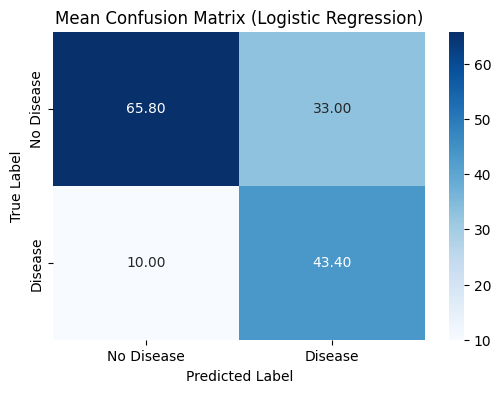

In [ ]:
print(f"Mean Accuracy (Logistic Regression): {np.mean(accuracies):.4f}")
# แสดงค่าเฉลี่ยของ Confusion Matrix
mean_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(6, 4))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Mean Confusion Matrix (Logistic Regression)")
plt.show()

######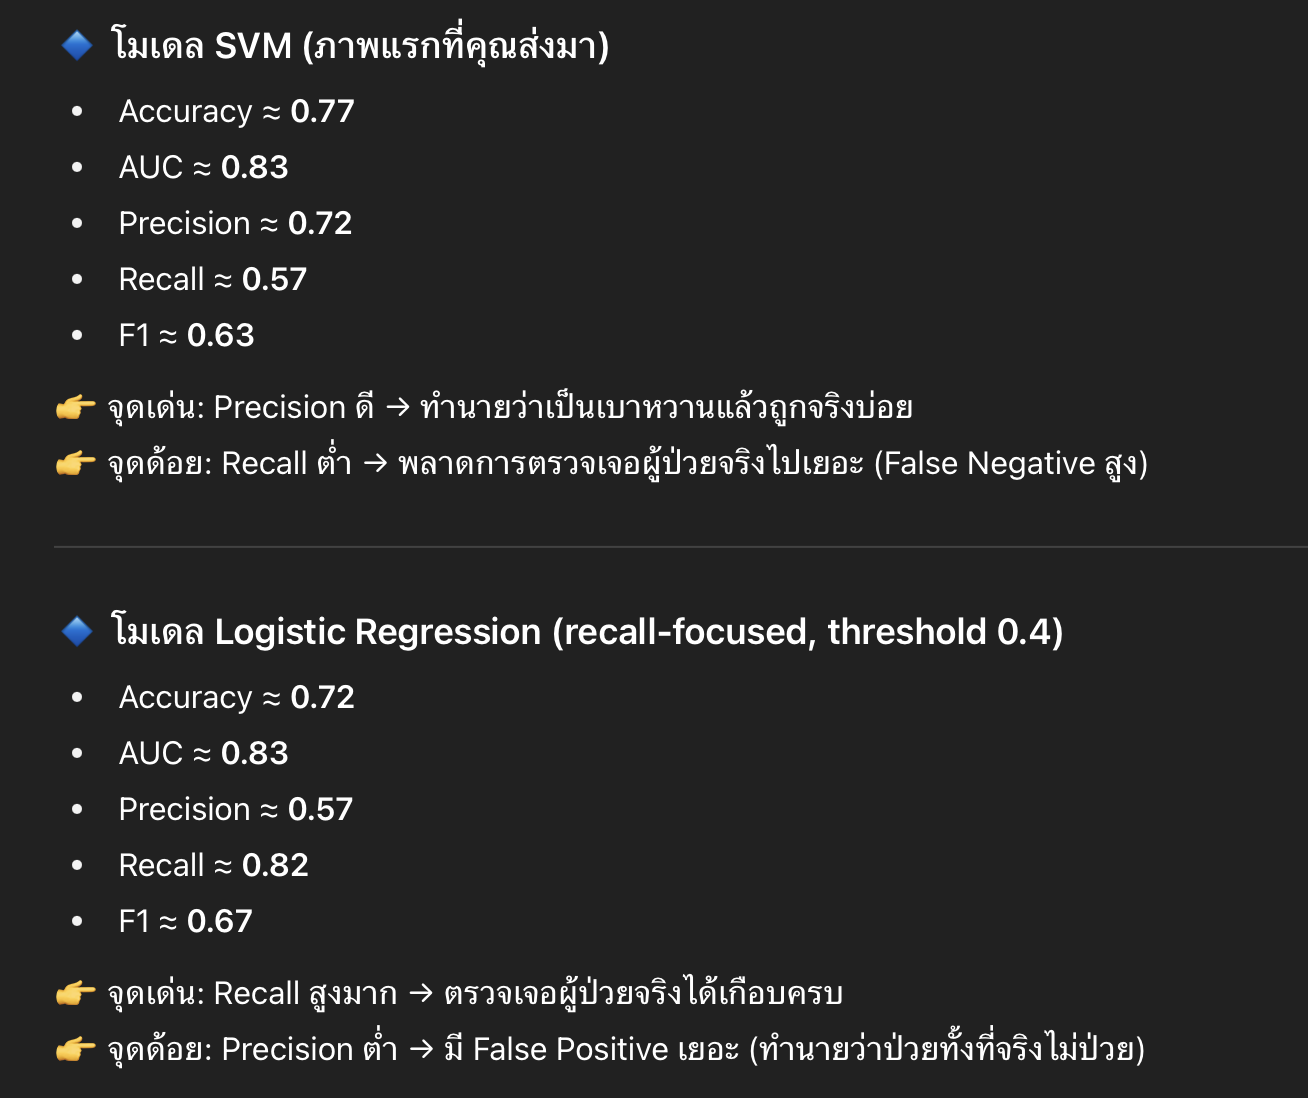

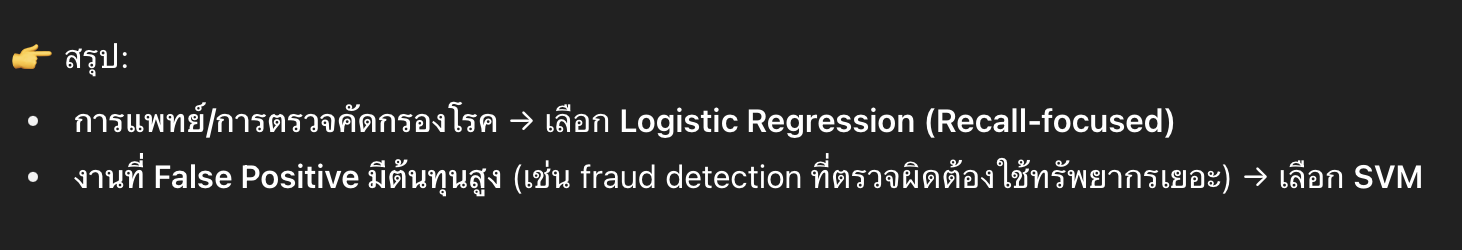

#### Stepwise

In [ ]:
# ----- แบ่ง train/test -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def stepwise_logit_pvalue(X, y, threshold_in=0.05, threshold_out=0.05, verbose=True):
    """
    Stepwise selection (forward + backward) สำหรับ Logistic Regression
    เกณฑ์คัดเลือกใช้ p-value ของค่าสัมประสิทธิ์
    """
    X = X.copy().reset_index(drop=True)
    y = y.copy().reset_index(drop=True)

    included = []
    excluded = list(X.columns)
    round_num = 1

    if verbose:
        print("🔁 Stepwise Logistic (p-value based)")

    while True:
        changed = False

        # ---------- Forward step ----------
        pvals_forward = pd.Series(index=excluded, dtype=float)
        for col in excluded:
            cols = included + [col]
            try:
                model = sm.Logit(y, sm.add_constant(X[cols], has_constant='add')).fit(disp=0)
                pvals_forward[col] = model.pvalues.get(col, 1.0)
            except Exception:
                pvals_forward[col] = 1.0

        if not pvals_forward.empty:
            best_feat = pvals_forward.idxmin()
            best_p = pvals_forward.min()
            if best_p < threshold_in:
                included.append(best_feat)
                excluded.remove(best_feat)
                changed = True
                if verbose:
                    print(f"  🔼 Round {round_num}: add {best_feat} (p={best_p:.4f})")

        # ---------- Backward step ----------
        if included:
            model = sm.Logit(y, sm.add_constant(X[included], has_constant='add')).fit(disp=0)
            pvals_back = model.pvalues.drop('const')
            worst_feat = pvals_back.idxmax()
            worst_p = pvals_back.max()
            if worst_p > threshold_out:
                included.remove(worst_feat)
                excluded.append(worst_feat)
                changed = True
                if verbose:
                    print(f"  🔽 Round {round_num}: drop {worst_feat} (p={worst_p:.4f})")

        if not changed:
            if verbose:
                print("✅ Finished.\n")
            break
        round_num += 1

    final_model = sm.Logit(y, sm.add_constant(X[included], has_constant='add')).fit(disp=0)
    return included, final_model

# ----- รัน stepwise บน TRAIN -----
features_sel, model_final = stepwise_logit_pvalue(X_train, y_train, threshold_in=0.05, threshold_out=0.10, verbose=True)

print("📊 Selected features:", features_sel)
print(model_final.summary())

# ----- ประเมินบน TEST -----
X_test_sel = sm.add_constant(X_test[features_sel], has_constant='add')
y_prob = model_final.predict(X_test_sel)            # probability class=1
THRESHOLD = 0.50                                    # ปรับได้ เช่น 0.40 ถ้าจะดัน Recall
y_pred = (y_prob >= THRESHOLD).astype(int)

print("\n========== Test Metrics ==========")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
print(f"AUC      : {roc_auc_score(y_test, y_prob):.4f}")

🔁 Stepwise Logistic (p-value based)
  🔼 Round 1: add Glucose (p=0.0000)
  🔼 Round 2: add BMI (p=0.0000)
  🔼 Round 3: add Pregnancies_log (p=0.0000)
  🔼 Round 4: add DiabetesPedigreeFunction (p=0.0013)
  🔼 Round 5: add BMI_log (p=0.0350)
✅ Finished.

📊 Selected features: ['Glucose', 'BMI', 'Pregnancies_log', 'DiabetesPedigreeFunction', 'BMI_log']
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  608
Model:                          Logit   Df Residuals:                      602
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 Oct 2025   Pseudo R-squ.:                  0.2910
Time:                        15:36:19   Log-Likelihood:                -279.17
converged:                       True   LL-Null:                       -393.77
Covariance Type:            nonrobust   LLR p-value:                 1.582e-47
                    

Shapiro-Wilk Test Statistic = 0.8766128495380857
p-value = 4.454376505001865e-24


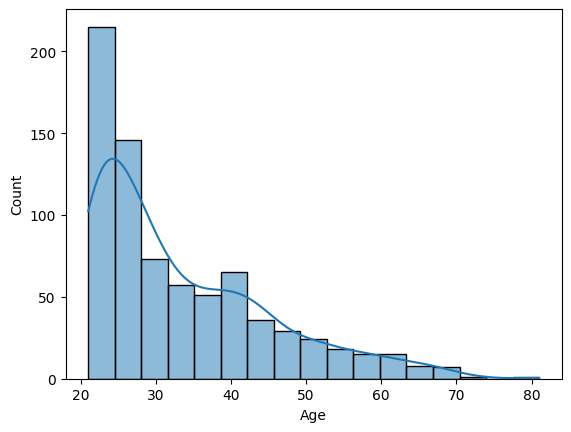

In [ ]:
stat, p_value = stats.shapiro(df["Age"])

print("Shapiro-Wilk Test Statistic =", stat)
print("p-value =", p_value)

sns.histplot(df['Age'], kde=True)  # เปลี่ยน target_variable เป็นชื่อจริงของตัวแปรเป้าหมาย
plt.show()